# Produit matriciel avec une matrice creuse

Les dictionnaires sont une façon assez de représenter les matrices creuses en ne conservant que les coefficients non nuls. Comment écrire alors le produit matriciel ?

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Matrice creuse et dictionnaire

Une [matrice creuse](https://fr.wikipedia.org/wiki/Matrice_creuse) ou [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix) est constituée majoritairement de 0. On utilise un dictionnaire avec les coefficients non nuls. La fonction suivante pour créer une matrice aléatoire.

In [2]:
import random

def random_matrix(n, m, ratio=0.1):
    mat = {}
    nb = min(n * m, int(ratio * n * m + 0.5))
    while len(mat) < nb:
        i = random.randint(0, n-1)
        j = random.randint(0, m-1)
        mat[i, j] = 1
    last = (n - 1, m - 1)
    if last not in mat:
        # pour être sûr que la matrice a les bonnes dimensions
        mat[last] = 0
    return mat

mat = random_matrix(3, 3, ratio=0.5)
mat

{(2, 2): 1, (0, 1): 1, (1, 1): 1, (2, 0): 1, (1, 0): 1}

## Calcul de la dimension

Pour obtenir la dimension de la matrice, il faut parcourir toutes les clés du dictionnaire.

In [3]:
def dimension(mat):
    maxi, maxj = 0, 0
    for k in mat:
        maxi = max(maxi, k[0])
        maxj = max(maxj, k[1])
    return maxi + 1, maxj + 1

dimension(mat)

(3, 3)

Cette fonction possède l'inconvénient de retourner une valeur fausse si la matrice ne possède aucun coefficient non nul sur la dernière ligne ou la dernière colonne. Cela peut être embarrassant, tout dépend de l'usage.

## Produit matriciel classique

On implémente le produit matriciel classique, à trois boucles.

In [4]:
def produit_classique(m1, m2):
    dim1 = dimension(m1)
    dim2 = dimension(m2)
    if dim1[1] != dim2[0]:
        raise Exception("Impossible de multiplier {0}, {1}".format(dim1, dim2))
    res = {}
    for i in range(dim1[0]):
        for j in range(dim2[1]):
            s = 0
            for k in range(dim1[1]):
                s += m1.get((i, k), 0) * m2.get((k, j), 0)
            if s != 0:  # Pour éviter de garder les coefficients non nuls.
                res[i, j] = s            
    return res

simple = {(0, 1): 1, (1, 0): 1}
produit_classique(simple, simple)

{(0, 0): 1, (1, 1): 1}

Sur la matrice aléatoire...

In [5]:
produit_classique(mat, mat)

{(0, 0): 1, (0, 1): 1, (1, 0): 1, (1, 1): 2, (2, 0): 1, (2, 1): 1, (2, 2): 1}

## Produit matriciel plus élégant

A-t-on vraiment besoin de s'enquérir des dimensions de la matrice pour faire le produit matriciel ? Ne peut-on pas tout simplement faire une boucle sur les coefficients non nul ?

In [6]:
def produit_elegant(m1, m2):
    res = {}
    for (i, k1), v1 in m1.items():
        if v1 == 0:
            continue
        for (k2, j), v2 in m2.items(): 
            if v2 == 0:
                continue
            if k1 == k2:
                if (i, j) in res:
                    res[i, j] += v1 * v2
                else :
                    res[i, j] = v1 * v2
    return res

produit_elegant(simple, simple)

{(0, 0): 1, (1, 1): 1}

In [7]:
produit_elegant(mat, mat)

{(2, 2): 1, (2, 0): 1, (0, 1): 1, (0, 0): 1, (1, 1): 2, (1, 0): 1, (2, 1): 1}

## Mesure du temps

A priori, la seconde méthode est plus rapide puisque son coût est proportionnel au produit du nombre de coefficients non nuls dans les deux matrices. Vérifions.

In [8]:
bigmat = random_matrix(100, 100)
%timeit produit_classique(bigmat, bigmat)

414 ms ± 29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit produit_elegant(bigmat, bigmat)

99.9 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


C'est beaucoup mieux. Mais peut-on encore faire mieux ?

## Dictionnaires de dictionnaires

Ca sonne un peu comme [mille millions de mille sabords](https://fr.wikipedia.org/wiki/Vocabulaire_du_capitaine_Haddock) mais le dictionnaire que nous avons créé a pour clé un couple de coordonnées et valeur des coefficients. La fonction ``produit_elegant`` fait plein d'itérations inutiles en quelque sorte puisque les coefficients sont nuls. Peut-on éviter ça ?

Et si on utilisait des dictionnaires de dictionnaires : ``{ ligne : { colonne : valeur } }``.

In [10]:
def matrice_dicodico(mat):
    res = {}
    for (i, j), v in mat.items():
        if i not in res:
            res[i] = {j: v}
        else:
            res[i][j] = v
    return res

matrice_dicodico(simple)

{0: {1: 1}, 1: {0: 1}}

Peut-on adapter le calcul matriciel élégant ? Il reste à associer les indices de colonnes de la première avec les indices de lignes de la seconde. Cela pose problème en l'état quand les indices de colonnes sont inaccessibles sans connaître les indices de lignes d'abord à moins d'échanger l'ordre pour la seconde matrice.

In [11]:
def matrice_dicodico_lc(mat, ligne=True):
    res = {}
    if ligne:
        for (i, j), v in mat.items():
            if i not in res:
                res[i] = {j: v}
            else:
                res[i][j] = v
    else:
        for (j, i), v in mat.items():
            if i not in res:
                res[i] = {j: v}
            else:
                res[i][j] = v
    return res

matrice_dicodico_lc(simple, ligne=False)

{1: {0: 1}, 0: {1: 1}}

Maintenant qu'on a fait ça, on peut songer au produit matriciel.

In [12]:
def produit_elegant_rapide(m1, m2):
    res = {}
    for k, vs in m1.items():
        if k in m2:
            for i, v1 in vs.items():
                for j, v2 in m2[k].items():
                    if (i, j) in res:
                        res[i, j] += v1 * v2
                    else :
                        res[i, j] = v1 * v2

    return res

m1 = matrice_dicodico_lc(simple, ligne=False)
m2 = matrice_dicodico_lc(simple)
produit_elegant_rapide(m1, m2)

{(0, 0): 1, (1, 1): 1}

In [13]:
m1 = matrice_dicodico_lc(mat, ligne=False)
m2 = matrice_dicodico_lc(mat)
produit_elegant_rapide(m1, m2)

{(2, 2): 1, (2, 0): 1, (0, 1): 1, (0, 0): 1, (1, 1): 2, (1, 0): 1, (2, 1): 1}

On mesure le temps avec une grande matrice.

In [14]:
m1 = matrice_dicodico_lc(bigmat, ligne=False)
m2 = matrice_dicodico_lc(bigmat)
%timeit produit_elegant_rapide(m1, m2)

3.25 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Beaucoup plus rapide, il n'y a plus besoin de tester les coefficients non nuls. La comparaison n'est pas très juste néanmoins car il faut transformer les deux matrices avant de faire le calcul. Et si on l'incluait ?

In [15]:
def produit_elegant_rapide_transformation(mat1, mat2):
    m1 = matrice_dicodico_lc(mat1, ligne=False)
    m2 = matrice_dicodico_lc(mat2)
    return produit_elegant_rapide(m1, m2)

produit_elegant_rapide_transformation(simple, simple)

{(0, 0): 1, (1, 1): 1}

In [16]:
%timeit produit_elegant_rapide_transformation(bigmat, bigmat)

3.58 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Finalement ça vaut le coup... mais est-ce le cas pour toutes les matrices.

In [17]:
%matplotlib inline

In [18]:
import time
mesures = []

for ratio in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
    big = random_matrix(100, 100, ratio=ratio)
    
    t1 = time.perf_counter()
    produit_elegant_rapide_transformation(big, big)
    t2 = time.perf_counter()
    dt = (t2 - t1)
    obs = {"dicodico": dt, "ratio": ratio}
    
    if ratio <= 0.3:
        # après c'est trop lent
        t1 = time.perf_counter()
        produit_elegant(big, big)
        t2 = time.perf_counter()
        dt = (t2 - t1)
        obs["dico"] = dt
    
    t1 = time.perf_counter()
    produit_classique(big, big)
    t2 = time.perf_counter()
    dt = (t2 - t1)
    obs["classique"] = dt

    mesures.append(obs)
    print(obs)    

{'dicodico': 0.012003499999998724, 'ratio': 0.1, 'dico': 0.10777440000000027, 'classique': 0.3187974000000011}
{'dicodico': 0.014974200000001048, 'ratio': 0.2, 'dico': 0.3366258000000002, 'classique': 0.3435348000000005}
{'dicodico': 0.03159210000000101, 'ratio': 0.3, 'dico': 0.7631177000000022, 'classique': 0.3299744000000011}
{'dicodico': 0.05182399999999987, 'ratio': 0.4, 'classique': 0.36676549999999963}
{'dicodico': 0.09054219999999802, 'ratio': 0.5, 'classique': 0.3490755000000014}
{'dicodico': 0.10983819999999866, 'ratio': 0.6, 'classique': 0.382511700000002}
{'dicodico': 0.2340966999999985, 'ratio': 0.7, 'classique': 0.36933710000000275}
{'dicodico': 0.3196471999999986, 'ratio': 0.8, 'classique': 0.40243699999999905}
{'dicodico': 0.35430310000000276, 'ratio': 0.9, 'classique': 0.44061049999999824}
{'dicodico': 0.3136302999999998, 'ratio': 0.99, 'classique': 0.4038351999999996}


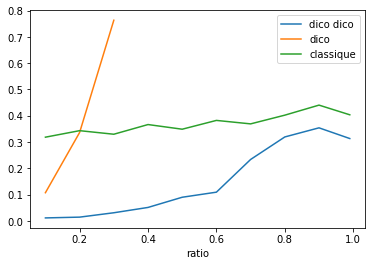

In [19]:
from pandas import DataFrame
df = DataFrame(mesures)
ax = df.plot(x="ratio", y="dicodico", label="dico dico")
df.plot(x="ratio", y="dico", label="dico", ax=ax)
df.plot(x="ratio", y="classique", label="classique", ax=ax)
ax.legend();

Cette dernière version est efficace.